### Testing convolutional neural network (CNN)


## Import the required libraries

In [1]:
import PIL
import csv
import pathlib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle


from torch.utils.data import Dataset,DataLoader,random_split
from typing import Any,Tuple,Optional,Callable
from torch.optim import Adam,lr_scheduler
from torchvision.transforms.v2 import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import torch.utils.data

from torchvision import models, datasets, tv_tensors

from sklearn.metrics import accuracy_score

## Select gpu accelerator if possible

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You will be running this notebook on {device}")

You will be running this notebook on cuda


## Make a custom class for the gtsrb dataset

In [4]:
class GTSRB(Dataset):


    def __init__(self,
                 root: str,
                 split: str,
                 transform: Optional[Callable] = None):

        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split =='train' else 'Test.csv')

        # Change this according to your system
        with open(str(self.csv_file)) as csvfile:
           samples = [(str(self.base_folder / row['Path']),int(row['ClassId']))
            for row in csv.DictReader(csvfile,delimiter=',',skipinitialspace=True)
                ]


        self.samples = samples
        self.split = split
        self.transform = transform


    def __len__(self):

        return len(self.samples)


    def __getitem__(self, index: int) -> Tuple:

        path,classId =  self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)

        return sample,classId


## Augmenting data by applying some transformations, such as brightness, contrast, vertical-horizontal flip, rotations and blur

In [5]:
train_transforms = Compose(
    [
        ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
        RandomEqualize(0.4),
        AugMix(),
        RandomHorizontalFlip(0.3),
        RandomVerticalFlip(0.3),
        GaussianBlur((3,3)),
        RandomRotation(30),
        Resize([50,50]),
        ToTensor()
    ]
)
validation_transforms =  Compose(
    [
        Resize([50,50]),
        ToTensor()
    ]
)

c:\Users\Midnight Commander\Documents\Study\Course_Work\signs-classification\venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## splitting dataset into train and validation

In [6]:
def train_test_split(dataset,train_size):

    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)

    return random_split(dataset,[train_size,test_size])

In [8]:
dataset = GTSRB(root='data',split="train")
train_set,validation_set = train_test_split(dataset,train_size=0.8)
print(f'training size : {len(train_set)}, Validation size : {len(validation_set)}')

training size : 31367, Validation size : 7842


# Visualize the data to check if everytrhing is okay

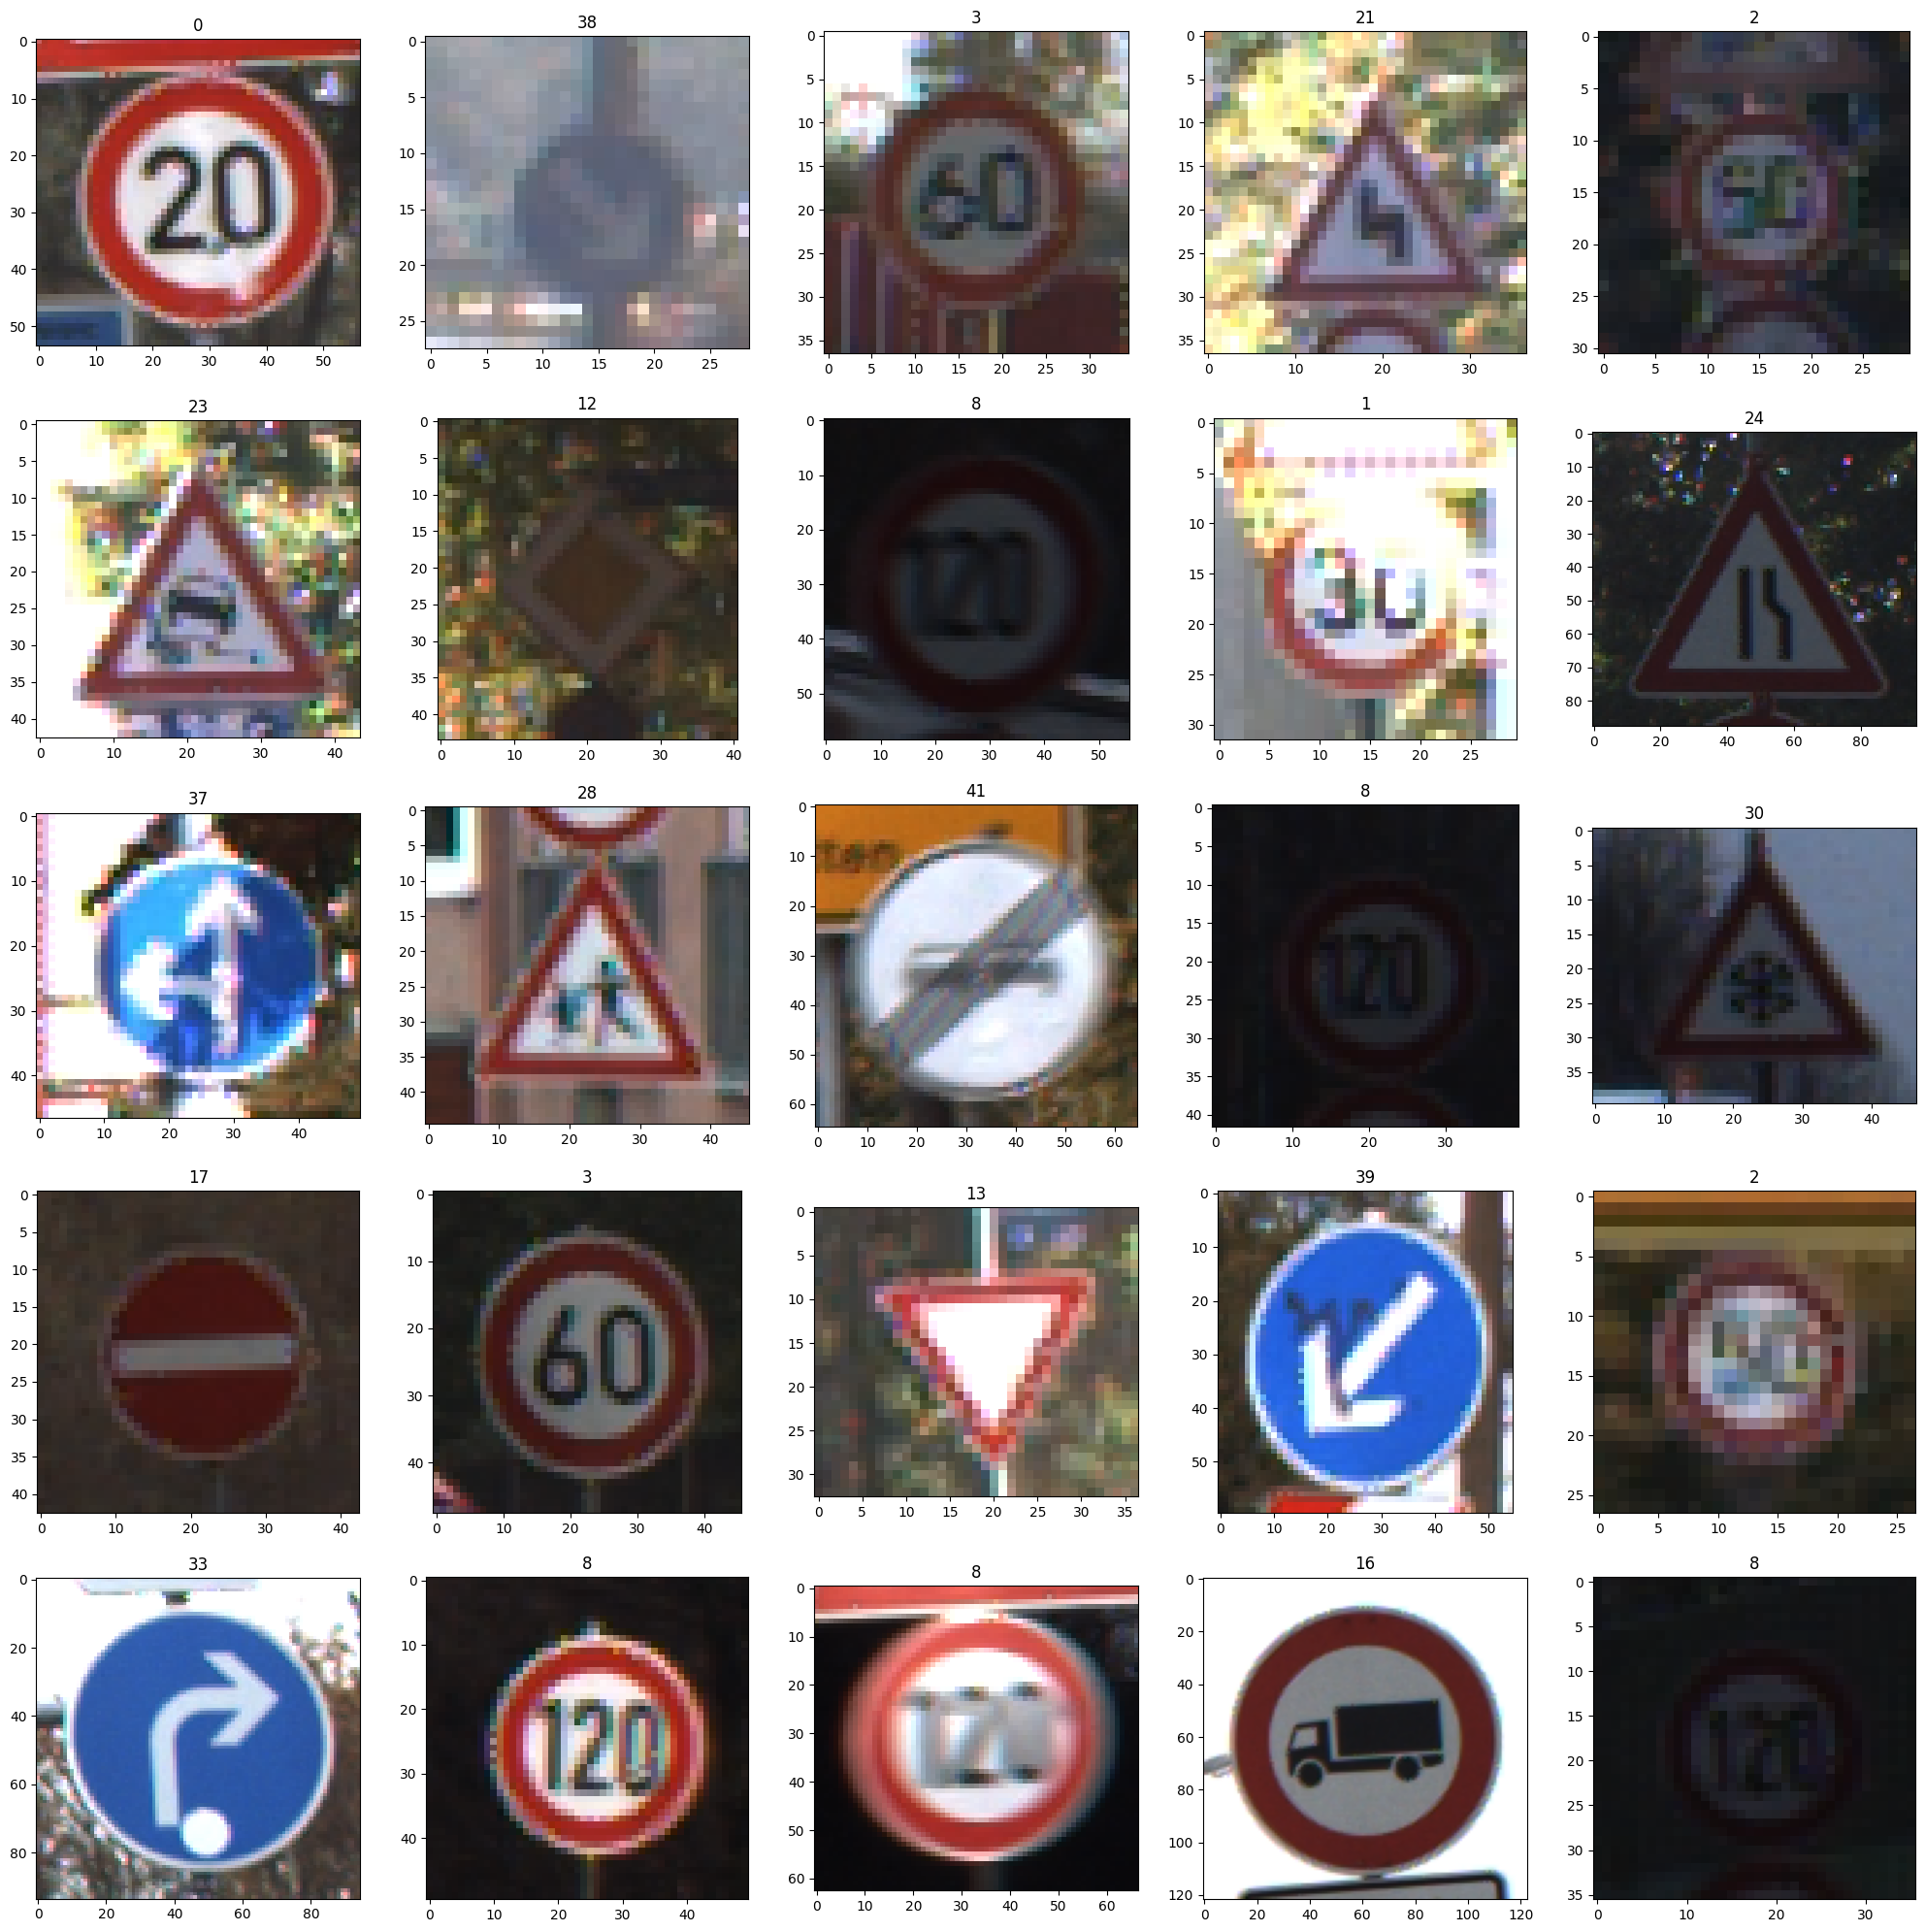

In [22]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    input,label = train_set[i]
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)


## Apply the transformations

In [9]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms

## Load train and validation data

In [10]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
validation_loader = DataLoader(dataset=validation_set,batch_size=BATCH_SIZE)

## Build a convolutional neural network model

In [11]:
class GTSRB_MODEL(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initializing the model
        """

        super(GTSRB_MODEL,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.metrics = {}

        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # building layers
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)


        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_dim)


    def forward(self, input):
        """
        Forward propagation...
        """

        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)

        flatten = self.flatten(maxpool)

        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)


        return output


    def training_metrics(self, positives, data_size, loss):
        """
        Calculates accuracy score for training dataset.

        Args:
        positives (int): Counter of correct predictions
        data_size (int): length of training dataset
        loss (float): value of Loss fucntion

        Returns:
        loss (float): value of Loss fucntion
        accuracy (float): Accuracy score

        """

        accuracy = positives/data_size

        return loss, accuracy


    def validation_metrics(self, validation_data, loss_function):
        """
        Calculates accuracy score for validation dataset.

        Args:
        validation_data (list): Validation dataset
        loss_function

        Returns:
        val_loss (float): value of Loss fucntion
        val_accuracy (float): Accuracy score

        """

        data_size = len(validation_data)
        correct_predictions = 0
        total_samples = 0
        val_loss = 0

        model = self.eval()
        with torch.no_grad():
            for step,(input,label) in enumerate(validation_data):
                input,label = input.to(device),label.to(device)
                prediction = model.forward(input)
                loss = loss_function(prediction,label)
                val_loss = loss.item()
                _,predicted = torch.max(prediction,1)
                correct_predictions += (predicted == label).sum().item()
                total_samples += label.size(0)

        val_accuracy = correct_predictions/total_samples

        return val_loss, val_accuracy


    def history(self):

        return self.metrics


    def compile(self, train_data, validation_data, epochs, loss_function,
                optimizer, learning_rate_scheduler):
        """
        Model training process.

        Args:
        train_data (list): train dataset
        validation_data (list): validation dataset
        epochs (int): number of epochs
        loss_function (function)
        optimizer (function)
        learning_rate_scheduler (function)
        """
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('Beginning training...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'blue'
                    progress.desc = (f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}],'
                                     f'Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}],'
                                     f'Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]')
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            learning_rate_scheduler.step()

        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('Training complete!')



## Train our model

In [13]:
import tqdm
EPOCHS = 20
LEARNING_RATE = 0.0008
INPUT_DIM = 3*50*50
OUTPUT_DIM = 43
model = GTSRB_MODEL(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()


In [45]:
model.compile(train_data=train_loader,validation_data=validation_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

Beginning training...


Epoch [0/20], Step [490/491],Learning Rate [0.0008], Loss [0.2189],Accuracy [0.6559]: 100%|██████████| 491/491 [00:20<00:00, 23.67it/s]


val_accuracy [0.978321856669217], val_loss [0.14827825129032135]


Epoch [1/20], Step [490/491],Learning Rate [0.00076], Loss [0.0323],Accuracy [0.9854]: 100%|██████████| 491/491 [00:19<00:00, 25.63it/s]


val_accuracy [0.9943891864320327], val_loss [0.041009385138750076]


Epoch [2/20], Step [490/491],Learning Rate [0.00072], Loss [0.0897],Accuracy [0.9964]: 100%|██████████| 491/491 [00:19<00:00, 25.80it/s]


val_accuracy [0.9892884468247896], val_loss [0.046517230570316315]


Epoch [3/20], Step [490/491],Learning Rate [0.00068], Loss [0.0008],Accuracy [0.9985]: 100%|██████████| 491/491 [00:23<00:00, 20.50it/s]


val_accuracy [0.993369038510584], val_loss [0.025549670681357384]


Epoch [4/20], Step [490/491],Learning Rate [0.00064], Loss [0.0007],Accuracy [0.9999]: 100%|██████████| 491/491 [00:29<00:00, 16.55it/s]


val_accuracy [0.9974496301963784], val_loss [0.0028384339530020952]


Epoch [5/20], Step [490/491],Learning Rate [0.0006000000000000001], Loss [0.0006],Accuracy [1.0000]: 100%|██████████| 491/491 [00:22<00:00, 21.38it/s]


val_accuracy [0.9988523335883703], val_loss [0.0010533021995797753]


Epoch [6/20], Step [490/491],Learning Rate [0.0005600000000000001], Loss [0.0002],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 25.67it/s]


val_accuracy [0.9991073705687324], val_loss [0.0006440146826207638]


Epoch [7/20], Step [490/491],Learning Rate [0.0005200000000000001], Loss [0.0002],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 25.40it/s]


val_accuracy [0.9991073705687324], val_loss [0.0005359072238206863]


Epoch [8/20], Step [490/491],Learning Rate [0.00048000000000000007], Loss [0.0003],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 25.08it/s]


val_accuracy [0.9991073705687324], val_loss [0.0004378268786240369]


Epoch [9/20], Step [490/491],Learning Rate [0.00044000000000000007], Loss [0.0001],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 24.98it/s]


val_accuracy [0.9992348890589136], val_loss [0.000318320730002597]


Epoch [10/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0001],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 25.59it/s]


val_accuracy [0.9992348890589136], val_loss [0.0002606021298561245]


Epoch [11/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0001],Accuracy [1.0000]: 100%|██████████| 491/491 [00:20<00:00, 23.67it/s]


val_accuracy [0.9992348890589136], val_loss [0.0002100048295687884]


Epoch [12/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0001],Accuracy [1.0000]: 100%|██████████| 491/491 [00:20<00:00, 23.43it/s]


val_accuracy [0.9994899260392757], val_loss [0.00019733459339477122]


Epoch [13/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0001],Accuracy [1.0000]: 100%|██████████| 491/491 [00:21<00:00, 23.00it/s]


val_accuracy [0.9993624075490947], val_loss [0.0001402788911946118]


Epoch [14/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0000],Accuracy [1.0000]: 100%|██████████| 491/491 [00:20<00:00, 24.06it/s]


val_accuracy [0.9992348890589136], val_loss [0.00011081365664722398]


Epoch [15/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0000],Accuracy [1.0000]: 100%|██████████| 491/491 [00:20<00:00, 24.05it/s]


val_accuracy [0.9994899260392757], val_loss [9.077408321900293e-05]


Epoch [16/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0000],Accuracy [1.0000]: 100%|██████████| 491/491 [00:20<00:00, 24.28it/s]


val_accuracy [0.9993624075490947], val_loss [7.033569272607565e-05]


Epoch [17/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0000],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 24.99it/s]


val_accuracy [0.9993624075490947], val_loss [5.1517985411919653e-05]


Epoch [18/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0000],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 25.68it/s]


val_accuracy [0.9992348890589136], val_loss [4.309459473006427e-05]


Epoch [19/20], Step [490/491],Learning Rate [0.0004000000000000001], Loss [0.0000],Accuracy [1.0000]: 100%|██████████| 491/491 [00:19<00:00, 25.76it/s]


val_accuracy [0.9993624075490947], val_loss [3.254028342780657e-05]
Training complete!


In [22]:
model

GTSRB_MODEL(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_fe

## Results on test dataset

In [16]:
transforms = Compose(
    [
        Resize([50,50]),
        ToTensor(),
    ]
)

testdata = GTSRB(root='data',split='test',transform=transforms)
test_dataloader = DataLoader(testdata)
print('testing size :',len(testdata))

testing size : 12630


In [17]:
y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='green',total=len(test_dataloader)) as progress:

  with torch.no_grad() :
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())

        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)


Test Accuracy : 0.9912905779889153 : 100%|██████████| 12630/12630 [01:14<00:00, 169.68it/s]


<Axes: >

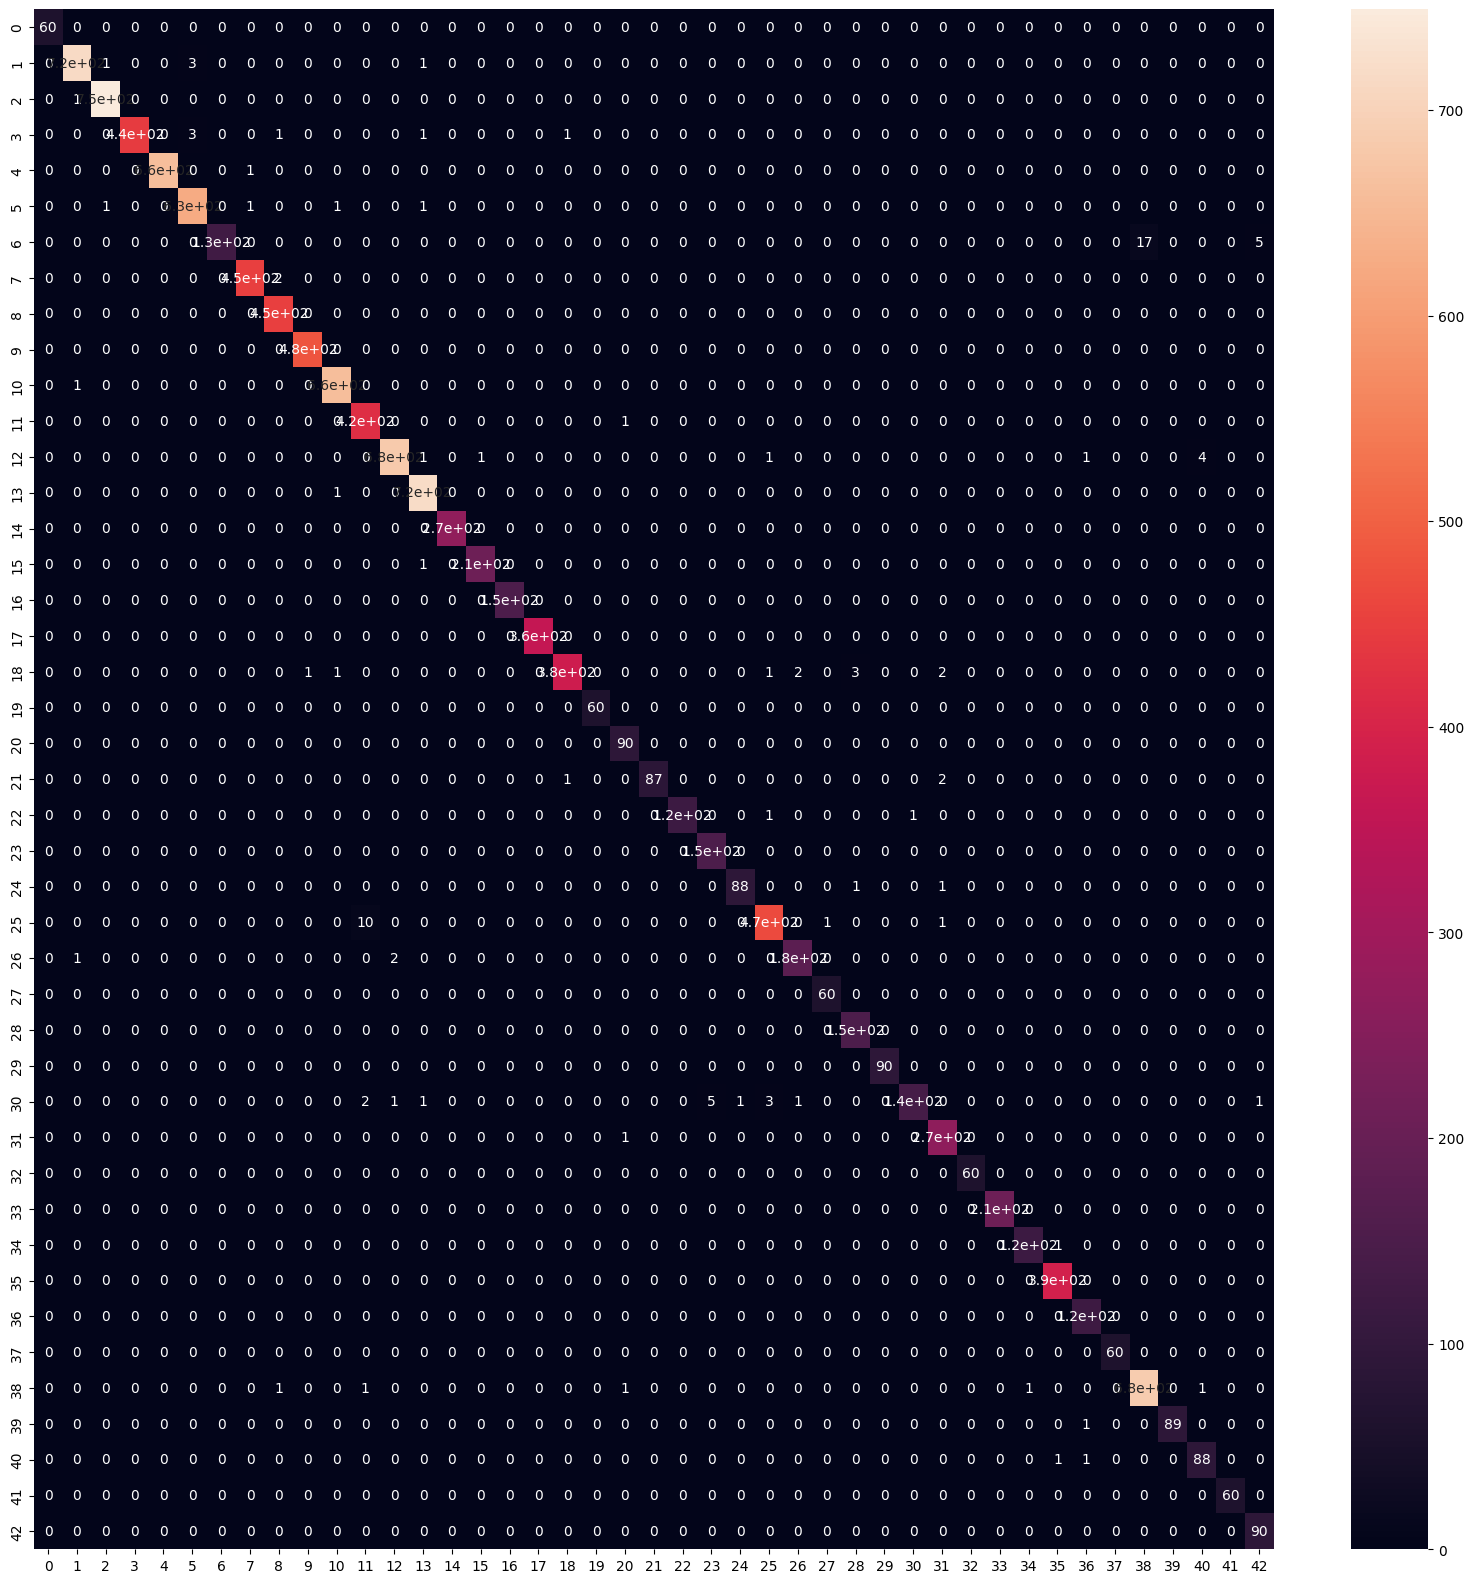

In [23]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.99      0.99       720
           2       1.00      1.00      1.00       750
           3       1.00      0.99      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      0.99      0.99       630
           6       1.00      0.85      0.92       150
           7       1.00      1.00      1.00       450
           8       0.99      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      1.00      0.98       420
          12       1.00      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Export model

In [50]:
torch.save(model.state_dict(), 'cnn_torch.pt')

In [14]:
model = GTSRB_MODEL(INPUT_DIM, OUTPUT_DIM)
model.load_state_dict(torch.load('cnn_torch.pt'))

<All keys matched successfully>